# COSMOLOGÍA
---
## Análisis de Correlación a 2 Puntos

## 1. Librerías y Parámetros
---

### 1.1. Librerías
---

In [1]:
from pathlib import Path
import requests
import time

import pandas as pd

import numpy as np
from scipy.integrate import quad
from scipy.spatial import cKDTree

from astropy.io import fits
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import treecorr

import matplotlib.pyplot as plt
"""
try:
    from Corrfunc.theory.DD import DD
except ImportError as e:
    raise ImportError("Instala Corrfunc o usa pycorr/treecorr.") from e

try:
    from pycorr import TwoPointCorrelationFunction
    import corrfunc
except ImportError as e:
    raise ImportError("Instala pycorr o usa treecorr.") from e
"""



'\ntry:\n    from Corrfunc.theory.DD import DD\nexcept ImportError as e:\n    raise ImportError("Instala Corrfunc o usa pycorr/treecorr.") from e\n\ntry:\n    from pycorr import TwoPointCorrelationFunction\n    import corrfunc\nexcept ImportError as e:\n    raise ImportError("Instala pycorr o usa treecorr.") from e\n'

### 1.2. Constantes y Parámetros

In [2]:
C_KM_S = 299792.458  # km/s

H0  = 67.66
Om0 = 0.3111

LSS_DATA_SOURCE = 'eBOSS'
Z_MIN = 0.6
Z_MAX = 1.0



## 2. Datos
---

### 2.1. Fuentes de Datos
----

#### 2.1.1 eBOSS
---

In [3]:
eboss_url_base    = "https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16"
eboss_file_data   = "eBOSS_LRG_clustering_data-NGC-vDR16.fits"
eboss_file_random = "eBOSS_LRG_clustering_random-NGC-vDR16.fits"
eboss_path        = "data/eboss"

### 2.2. Descarga de los Datos
---

In [4]:
def download(url: str, out: Path, chunk=2**20):
    out = Path(out)
    out.parent.mkdir(parents=True, exist_ok=True)
    if out.exists():
        print('Archivo previamente descargado:', out)
        return out
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out, "wb") as f:
            for b in r.iter_content(chunk_size=chunk):
                if b:
                    f.write(b)
    return out

def download_LSS(source: str = 'eBOSS'):
    if source == 'eBOSS':
        url_data    = f"{eboss_url_base}/{eboss_file_data}"
        url_random  = f"{eboss_url_base}/{eboss_file_random}"
        data_path   = f"{eboss_path}/{eboss_file_data}"
        rand_path   = f"{eboss_path}/{eboss_file_random}"
        
    download(url_data, data_path)
    download(url_random, rand_path)
    return data_path, rand_path

data_path, rand_path = download_LSS(source=LSS_DATA_SOURCE)

Archivo previamente descargado: data\eboss\eBOSS_LRG_clustering_data-NGC-vDR16.fits
Archivo previamente descargado: data\eboss\eBOSS_LRG_clustering_random-NGC-vDR16.fits


### 2.3. Carga de archvios de Datos
---

#### 2.3.1. Construye los asociados a los datos del archivo FITS
---

In [5]:
def build_weights_from_fits(fits_path, hdu=1, prefer_total=True):
    """
    Devuelve (weights, info_dict) para un catálogo LSS (data o random).
    - prefer_total: si existe una columna de peso total, usarla directamente.
    """
    with fits.open(fits_path, memmap=True) as hdul:
        tab = hdul[hdu].data
        cols = [c.upper() for c in tab.columns.names]

        def has(name): return name.upper() in cols
        def col(name): return np.array(tab[name], dtype=np.float64)

        info = {"source": str(fits_path), "used": []}

        # 1) Si existe una columna de peso total, úsala
        total_candidates = ["WEIGHT", "WEIGHT_TOT", "WEIGHT_TOTAL", "WEIGHT_ALL", "WEIGHT_F"]
        if prefer_total:
            for cname in total_candidates:
                if has(cname):
                    w = col(cname)
                    info["used"].append(cname)
                    return w, info

        # 2) Construir w_comp = WEIGHT_SYSTOT * WEIGHT_CP * WEIGHT_NOZ (si existen)
        w = np.ones(len(tab), dtype=np.float64)

        comp_factors = []
        for cname in ["WEIGHT_SYSTOT", "WEIGHT_CP", "WEIGHT_NOZ"]:
            if has(cname):
                w *= col(cname)
                comp_factors.append(cname)

        if comp_factors:
            info["used"].append("w_comp=" + "*".join(comp_factors))
        else:
            info["used"].append("w_comp=1")

        # 3) Multiplicar por WEIGHT_FKP si existe
        if has("WEIGHT_FKP"):
            w *= col("WEIGHT_FKP")
            info["used"].append("WEIGHT_FKP")
        else:
            info["used"].append("WEIGHT_FKP=1")

        return w, info


#### 2.3.2. Descarga datos en coordenadas RA, DEC, z ( + pesos)
---

In [6]:
def load_radec_z_and_w(fits_file, zmin=None, zmax=None):
    """
    Carga RA, DEC, Z y pesos w (float64) con corte opcional en z.
    """
    fits_path = Path(fits_file)
    with fits.open(fits_path, memmap=True) as hdul:
        tab = hdul[1].data
        cols = [c.upper() for c in tab.columns.names]
         # inspección rápida
        print(f"\nFITS File: {fits_path.name}: {len(tab)} rows")
        print("Columns (first 30):", cols[:30])

        # Redshift: Z o ZRED (típicos)
        if "Z" in cols:
            z = np.array(tab["Z"], dtype=np.float64)
        elif "ZRED" in cols:
            z = np.array(tab["ZRED"], dtype=np.float64)
        else:
            raise KeyError("No encuentro columna de redshift (Z o ZRED).")

        ra  = np.array(tab["RA"], dtype=np.float64)
        dec = np.array(tab["DEC"], dtype=np.float64)

    # Pesos (en segunda apertura o reusa, aquí simple):
    w, info = build_weights_from_fits(fits_path)

    m = np.ones_like(z, dtype=bool)
    if zmin is not None: m &= (z >= zmin)
    if zmax is not None: m &= (z <= zmax)

    return ra[m], dec[m], z[m], w[m], info

Z_MIN=0.6

ra_d, dec_d, z_d, w_d, info_d = load_radec_z_and_w(data_path, zmin=Z_MIN, zmax=Z_MAX)
ra_r, dec_r, z_r, w_r, info_r = load_radec_z_and_w(rand_path, zmin=Z_MIN, zmax=Z_MAX)
print('\n  DATA LOADED\n','-'*30)
print("  Data selected:", len(z_d), "rows")
print("  Rand selected:", len(z_r), "rows")



FITS File: eBOSS_LRG_clustering_data-NGC-vDR16.fits: 107500 rows
Columns (first 30): ['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_SYSTOT', 'WEIGHT_CP', 'WEIGHT_NOZ', 'NZ', 'LRG_ID']

FITS File: eBOSS_LRG_clustering_random-NGC-vDR16.fits: 5460719 rows
Columns (first 30): ['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_SYSTOT', 'WEIGHT_CP', 'WEIGHT_NOZ', 'NZ']

  DATA LOADED
 ------------------------------
  Data selected: 107500 rows
  Rand selected: 5460719 rows


### 2.4. Transformación de Coordenadas
---

#### 2.4.1. Conversión a Coordenadas Comoviles (astropy.cosmology)
---

In [7]:
def comoving_distance_mpc_over_h(z, H0=67.66, Om0=0.3111, to_Mpc_over_h=True):
    """
    Devuelve chi(z) en Mpc/h.
    """
    z = np.asarray(z, dtype=np.float64)
    if z.size == 0:
        return np.empty((0,), dtype=np.float64)
    cosmo = FlatLambdaCDM(H0=H0 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=Om0)
    chi = cosmo.comoving_distance(z).value  # Mpc
    if to_Mpc_over_h:
        h = H0 / 100.0
        chi = chi * h  # Mpc/h

    return chi

def radec_z_to_xyz(ra_deg, dec_deg, z,
                   H0=67.66, Om0=0.3111, 
                   to_Mpc_over_h=True):
    """
    Convierte (RA, DEC, z) -> (X, Y, Z) comóviles.
    - ra_deg, dec_deg en grados
    - z adimensional
    Devuelve X,Y,Z en Mpc/h (por defecto) o Mpc.
    """
    ra  = np.deg2rad(np.asarray(ra_deg, dtype=np.float64))
    dec = np.deg2rad(np.asarray(dec_deg, dtype=np.float64))
    z   = np.asarray(z, dtype=np.float64)
    chi = comoving_distance_mpc_over_h(z, H0, Om0)
    
    # distancia comóvil radial en Mpc (astropy)
    
    cosd = np.cos(dec)
    X = chi * cosd * np.cos(ra)
    Y = chi * cosd * np.sin(ra)
    Z = chi * np.sin(dec)
    return X, Y, Z

# Ejemplo de uso:
Xd, Yd, Zd = radec_z_to_xyz(ra_d, dec_d, z_d, H0 = H0, Om0 = Om0)
Xr, Yr, Zr = radec_z_to_xyz(ra_r, dec_r, z_r, H0 = H0, Om0 = Om0)


In [8]:
print(z_d.min(), z_d.max(),z_r.min(),z_r.max())

0.6000045864549145 0.9999874344230781 0.6000045864549145 0.9999874344230781


### 2.5. Proyección y Visualización
---

In [9]:
# ----------------------------
# Proyección a cuña (wedge)
# ----------------------------
def wedge_xy_from_ra(ra_deg, chi, ra_center_deg=None):
    """
    Convierte (RA, chi) -> (x,y) tipo cuña.
    theta se toma como RA centrada (en rad).
    """
    ra = np.asarray(ra_deg, dtype=np.float64)

    if ra_center_deg is None:
        # centro robusto: mediana
        ra_center_deg = np.nanmedian(ra)

    # Centrado en RA y wrap a [-180, 180]
    d = (ra - ra_center_deg + 180.0) % 360.0 - 180.0
    theta = np.deg2rad(d)

    x = chi * np.sin(theta)
    y = chi * np.cos(theta)
    return x, y, ra_center_deg

def random_subsample(ra, dec, z, frac=0.05, seed=1234):
    """
    Devuelve un submuestreo aleatorio de (ra,dec,z) conservando una fracción frac.
    - frac en (0,1]
    - seed fija reproducibilidad
    """
    ra = np.asarray(ra); dec = np.asarray(dec); z = np.asarray(z)
    n = len(z)
    if frac >= 1.0 or n == 0:
        return ra, dec, z

    rng = np.random.default_rng(seed)
    k = max(1, int(np.floor(frac * n)))
    idx = rng.choice(n, size=k, replace=False)
    return ra[idx], dec[idx], z[idx]

# ------------
# Plot: wedge 
# ------------
def plot_wedge(
    ra_d, dec_d, z_d,
    ra_r, dec_r, z_r,
    z_min=None, z_max=None,
    dec_min=10.0, dec_max=40.0,
    H0=67.66, Om0=0.3111,
    method="scatter",      # "scatter" o "hexbin"
    gridsize=280,          # para hexbin
    s_data=0.12, alpha_data=0.18,
    s_rand=0.05, alpha_rand=0.10,
    overlay_random=False,   # True: random debajo del data en el panel izquierdo
    frac_data=0.05,    
    frac_rand=0.01,    
    seed_data=1234,    
    seed_rand=42     
):
    """
    Wedge plot estilo LSS para un slice en DEC (hemisferio norte).
    Dos paneles: data (izq), random (dcha).
    """
    print("1. Applying Filter in DEC")
    # ---- 1) Filtro en DEC
    md_dec = (dec_d >= dec_min) & (dec_d <= dec_max)
    mr_dec = (dec_r >= dec_min) & (dec_r <= dec_max)

    ra_d1, dec_d1, z_d1 = ra_d[md_dec], dec_d[md_dec], z_d[md_dec]
    ra_r1, dec_r1, z_r1 = ra_r[mr_dec], dec_r[mr_dec], z_r[mr_dec]

    print("2. Applying Filter in z")
    # ---- 2) Filtro en z (opcional)
    if z_min is not None:
        m = (z_d1 >= z_min)
        ra_d1, dec_d1, z_d1 = ra_d1[m], dec_d1[m], z_d1[m]
        m = (z_r1 >= z_min)
        ra_r1, dec_r1, z_r1 = ra_r1[m], dec_r1[m], z_r1[m]

    if z_max is not None:
        m = (z_d1 <= z_max)
        ra_d1, dec_d1, z_d1 = ra_d1[m], dec_d1[m], z_d1[m]
        m = (z_r1 <= z_max)
        ra_r1, dec_r1, z_r1 = ra_r1[m], dec_r1[m], z_r1[m]

    print("3. SubSampling...")
     # ---- 3) SUBMUESTREO para el scatter (solo afecta al plot)
    ra_d1, dec_d1, z_d1 = random_subsample(ra_d1, dec_d1, z_d1, frac=frac_data, seed=seed_data)
    ra_r1, dec_r1, z_r1 = random_subsample(ra_r1, dec_r1, z_r1, frac=frac_rand, seed=seed_rand)

    print("3. Computing Comoving Distance...")
    # ---- 3) Distancia comóvil
    chi_d = comoving_distance_mpc_over_h(z_d1, H0=H0, Om0=Om0)
    chi_r = comoving_distance_mpc_over_h(z_r1, H0=H0, Om0=Om0)
    print("4. Computing Wedge Proyection")
    # ---- 4) Proyección wedge (mismo centro RA para data y random)
    x_d, y_d, ra0 = wedge_xy_from_ra(ra_d1, chi_d, ra_center_deg=None)
    x_r, y_r, _   = wedge_xy_from_ra(ra_r1, chi_r, ra_center_deg=ra0)
    print("5. Applying Limits")
    # ---- 5) Límites
    rmax = 0.0
    if len(chi_d): rmax = max(rmax, float(np.nanmax(chi_d)))
    if len(chi_r): rmax = max(rmax, float(np.nanmax(chi_r)))
    rmax = max(rmax, 1.0)
    print('6. Generating graphics...\n')
    # ---- 6) Figura (dos paneles horizontales)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # Panel A: DATA
    ax = axes[0]
    if overlay_random:
        if method == "hexbin":
            ax.hexbin(x_r, y_r, gridsize=gridsize, mincnt=1, linewidths=0, alpha=0.12)
        else:
            ax.scatter(x_r, y_r, s=s_rand, alpha=alpha_rand, rasterized=True)

    if method == "hexbin":
        hb = ax.hexbin(x_d, y_d, gridsize=gridsize, mincnt=1, linewidths=0, alpha=0.9)
        cb = fig.colorbar(hb, ax=ax, orientation="horizontal", pad=0.08, fraction=0.05)
        cb.set_label("Cuentas por celda (data)")
    else:
        ax.scatter(x_d, y_d, s=s_data, alpha=alpha_data, rasterized=True)

    ax.set_title("eBOSS/SDSS LRG (data) | DEC {dec_min}–{dec_max}°", fontsize=12)
    ax.set_aspect("equal", adjustable="box")
    ax.set_ylim(1000, rmax * 1.02)
    ax.set_xlim(-rmax * 0.35, rmax * 0.35)
    ax.axhline(0, lw=0.8, alpha=0.25)
    ax.grid(alpha=0.15)
    ax.set_xlabel(r"$\chi(z)\sin\theta\ \ [\mathrm{Mpc}/h]$")
    ax.set_ylabel(r"$\chi(z)\cos\theta\ \ [\mathrm{Mpc}/h]$")


    # Panel B: RANDOM
    ax = axes[1]
    if method == "hexbin":
        hb = ax.hexbin(x_r, y_r, gridsize=gridsize, mincnt=1, linewidths=0, alpha=0.9)
        cb = fig.colorbar(hb, ax=ax, orientation="horizontal", pad=0.08, fraction=0.05)
        cb.set_label("Cuentas por celda (random)")
    else:
        ax.scatter(x_r, y_r, s=s_rand, alpha=alpha_rand, rasterized=True)

    ax.set_title("eBOSS/SDSS LRG (random) | DEC {dec_min}–{dec_max}°", fontsize=12)
    ax.set_aspect("equal", adjustable="box")
    ax.set_ylim(1000, rmax * 1.02)
    ax.set_xlim(-rmax * 0.35, rmax * 0.35)
    ax.axhline(0, lw=0.8, alpha=0.25)
    ax.grid(alpha=0.15)
    ax.set_xlabel(r"$\chi(z)\sin\theta\ \ [\mathrm{Mpc}/h]$")


    # ---- 7) Anotaciones (info dentro del gráfico)
    ztxt = ""
    if z_min is not None or z_max is not None:
        zlo = z_min if z_min is not None else "-"
        zhi = z_max if z_max is not None else "-"
        ztxt = rf"$z\in[{zlo},{zhi}]$" + "\n"

    txtL = (
        rf"$\mathrm{{DEC}}\in[{dec_min:.0f}^\circ,{dec_max:.0f}^\circ]$" "\n"
        + ztxt +
        rf"$N_{{\rm gal}}={len(z_d1):,}$" "\n"
        rf"$\mathrm{{RA}}_0 \approx {ra0:.1f}^\circ$"
    )
    axes[0].text(
        0.02, 0.98, txtL,
        transform=axes[0].transAxes,
        ha="left", va="top",
        fontsize=10,
        bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.85)
    )

    ratio = len(z_r1) / max(len(z_d1), 1)
    txtR = (
        rf"$\mathrm{{DEC}}\in[{dec_min:.0f}^\circ,{dec_max:.0f}^\circ]$" "\n"
        + ztxt +
        rf"$N_{{\rm rand}}={len(z_r1):,}$" "\n"
        rf"$N_{{\rm rand}}/N_{{\rm gal}}\approx {ratio:.1f}$"
    )
    axes[1].text(
        0.02, 0.98, txtR,
        transform=axes[1].transAxes,
        ha="left", va="top",
        fontsize=10,
        bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.85)
    )

    fig.suptitle(f"Wedge plot: slice norte DEC {dec_min}–{dec_max}°", fontsize=14)
    plt.show()



1. Applying Filter in DEC
2. Applying Filter in z
3. SubSampling...
3. Computing Comoving Distance...
4. Computing Wedge Proyection
5. Applying Limits
6. Generating graphics...



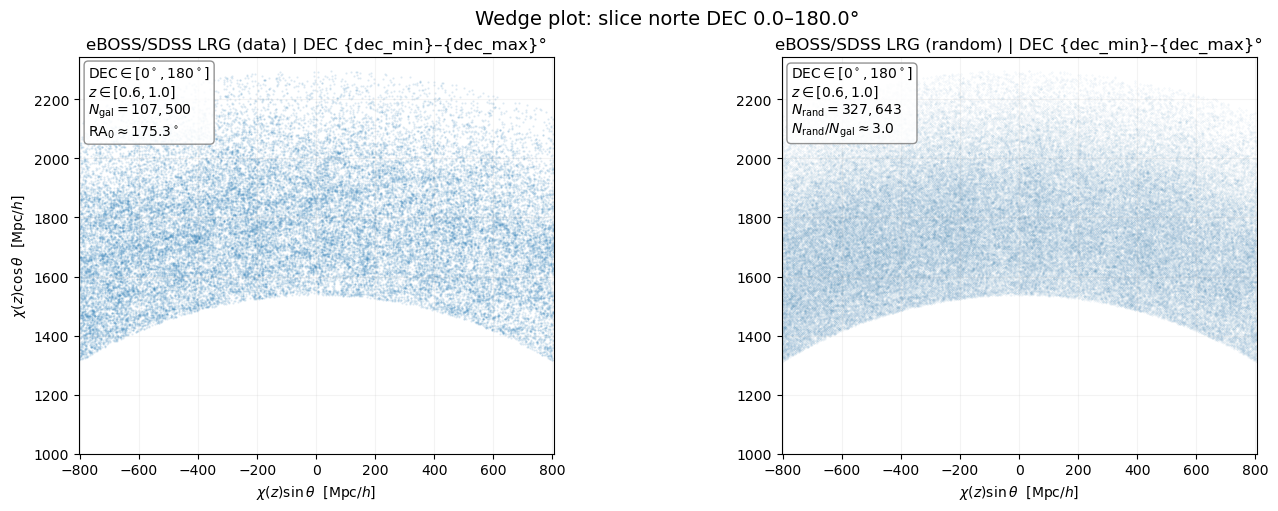

In [10]:
plot_wedge(
    ra_d, dec_d, z_d,
    ra_r, dec_r, z_r,
    z_min=0.6, z_max=1.0,     
    dec_min=0.0, dec_max=180.0,
    method="scatter",             # 'scatter',  "hexbin"
    s_data=0.25, alpha_data=0.15,
    s_rand=0.07, alpha_rand=0.10,
    overlay_random=False,
    frac_data=1.0,
    frac_rand=0.06,
    seed_data=42,
    seed_rand=7
)

###  Conversión a Coordenadas Comoviles (Alternativa: integración numérica directa)

In [11]:
def chi_of_z_LCDM(z, H0=67.66, Om0=0.3111):
    Ol0 = 1.0 - Om0

    def Ez(zp):
        return np.sqrt(Om0*(1.0+zp)**3 + Ol0)

    # chi en Mpc
    integral, _ = quad(lambda zp: 1.0/Ez(zp), 0.0, float(z), epsabs=1e-10, epsrel=1e-10)
    chi_mpc = (C_KM_S / H0) * integral
    return chi_mpc

def radec_z_to_xyz_quad(ra_deg, dec_deg, z, H0=67.66, Om0=0.3111, to_Mpc_over_h=True):
    ra  = np.deg2rad(np.asarray(ra_deg, dtype=np.float64))
    dec = np.deg2rad(np.asarray(dec_deg, dtype=np.float64))
    z   = np.asarray(z, dtype=np.float64)

    chi = np.array([chi_of_z_LCDM(zi, H0=H0, Om0=Om0) for zi in z], dtype=np.float64)

    if to_Mpc_over_h:
        h = H0/100.0
        chi *= h

    cosd = np.cos(dec)
    X = chi * cosd * np.cos(ra)
    Y = chi * cosd * np.sin(ra)
    Z = chi * np.sin(dec)
    return X, Y, Z

Xd_2, Yd_2, Zd_2 = radec_z_to_xyz_quad(ra_d, dec_d, z_d)
print(Xd[:10],Yd[10:])
print(Xd_2[:10],Yd_2[10:])


[ -720.03246363 -1225.20666945  -760.81595185 -1102.5050767
 -1175.05039198 -1316.3224732  -1382.03931307  -874.64206991
 -1241.31658083  -838.27711189] [1599.34948038 1653.12457836 1142.07684267 ...  -34.15243349  -38.19027249
  560.64744857]
[ -720.07783216 -1225.29480628  -760.86543509 -1102.57472747
 -1175.13063095 -1316.42701797 -1382.15559417  -874.71596631
 -1241.40952266  -838.3429177 ] [1599.46797502 1653.25322713 1142.14872069 ...  -34.15493568  -38.19334992
  560.68533769]


In [12]:
def plot_nz_data_vs_random(
    z_d, dec_d,
    z_r, dec_r,
    dec_min=10.0, dec_max=40.0,
    z_min=None, z_max=None,
    nbins=40,
    normalize=True,         # True: density=True (comparar shapes)
    logy=False
):
    """
    Histograma n(z) para data y random, con cortes en DEC y z.
    """

    # --- cortes en DEC
    md = (dec_d >= dec_min) & (dec_d <= dec_max)
    mr = (dec_r >= dec_min) & (dec_r <= dec_max)

    z_d1 = np.asarray(z_d[md], dtype=np.float64)
    z_r1 = np.asarray(z_r[mr], dtype=np.float64)

    # --- cortes en z (opcionales)
    if z_min is not None:
        z_d1 = z_d1[z_d1 >= z_min]
        z_r1 = z_r1[z_r1 >= z_min]
    if z_max is not None:
        z_d1 = z_d1[z_d1 <= z_max]
        z_r1 = z_r1[z_r1 <= z_max]

    if len(z_d1) == 0 or len(z_r1) == 0:
        raise ValueError("Tras los cortes, data o random se han quedado sin objetos.")

    # --- rango de bins
    zlo = z_min if z_min is not None else float(min(np.min(z_d1), np.min(z_r1)))
    zhi = z_max if z_max is not None else float(max(np.max(z_d1), np.max(z_r1)))
    edges = np.linspace(zlo, zhi, nbins + 1)

    # --- figura
    fig, ax = plt.subplots(1, 1, figsize=(9, 5), constrained_layout=True)

    # Hist normalizado vs absoluto
    density = bool(normalize)

    ax.hist(z_r1, bins=edges, density=density, histtype="step", linewidth=2,
            label="random")
    ax.hist(z_d1, bins=edges, density=density, histtype="step", linewidth=2,
            label="data")

    ax.set_xlabel(r"$z$")
    if density:
        ax.set_ylabel(r"$\hat p(z)$  (normalizado)")
    else:
        ax.set_ylabel(r"$n(z)$  (cuentas por bin)")

    ax.grid(alpha=0.2)
    if logy:
        ax.set_yscale("log")

    # --- anotación
    ratio = len(z_r1) / max(len(z_d1), 1)
    dz = (zhi - zlo) / nbins

    txt = (
        rf"$\mathrm{{DEC}}\in[{dec_min:.0f}^\circ,{dec_max:.0f}^\circ]$" "\n"
        rf"$z\in[{zlo:.2f},{zhi:.2f}]$" "\n"
        rf"$N_{{\rm gal}}={len(z_d1):,}$" "\n"
        rf"$N_{{\rm rand}}={len(z_r1):,}$" "\n"
        rf"$N_{{\rm rand}}/N_{{\rm gal}}\approx {ratio:.1f}$" "\n"
        rf"$N_{{\rm bins}}={nbins},\ \Delta z\approx {dz:.3f}$"
    )
    ax.text(
        0.75, 0.9, txt,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=10,
        bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.85)
    )

    ax.legend()
    ax.set_title(r"Distribución radial $n(z)$: data vs random", fontsize=13)

    plt.show()


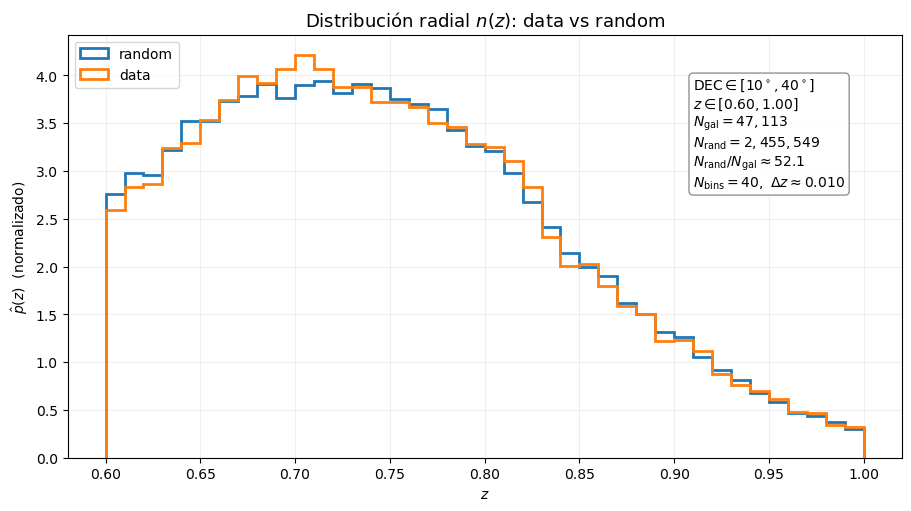

In [13]:
plot_nz_data_vs_random(
    z_d, dec_d,
    z_r, dec_r,
    dec_min=10, dec_max=40,
    z_min=0.6, z_max=1.0,
    nbins=40,
    normalize=True
)


## Correlación a 2 Puntos
---

## Metodo 0. Conteo Manual

In [14]:
pos_d = np.vstack([Xd, Yd, Zd]).T
pos_r = np.vstack([Xr, Yr, Zr]).T

def random_subsample_pos(pos, frac=1.0, seed=1234):
    """
    Submuestrea aleatoriamente un array pos shape (N,3).
    """
    pos = np.asarray(pos, dtype=np.float64)
    n = len(pos)
    if frac >= 1.0 or n == 0:
        return pos

    rng = np.random.default_rng(seed)
    k = max(1, int(np.floor(frac * n)))
    idx = rng.choice(n, size=k, replace=False)
    return pos[idx]

In [15]:

def paircounts_kdtree(pos1, pos2, edges, autocorr=False, verbose=True):
    """
    Cuenta pares entre pos1 y pos2 en bins radiales 'edges' (3D).
    Devuelve npairs por bin.

    autocorr=True si pos1 y pos2 son el MISMO catálogo (DD o RR),
    para corregir self-pairs (i=i).
    """
    pos1 = np.ascontiguousarray(pos1, dtype=np.float64)
    pos2 = np.ascontiguousarray(pos2, dtype=np.float64)

    tree1 = cKDTree(pos1)
    tree2 = cKDTree(pos2)

    cum = np.zeros(len(edges), dtype=np.float64)

    for k, rmax in enumerate(edges):
        if verbose:
            print('.', end='', flush=True)
        pairs = tree1.count_neighbors(tree2, rmax)

        # Corrección self-pairs en autocorr: para cualquier rmax>0,
        # count_neighbors incluye N pares (i,i).
        if autocorr and rmax > 0:
            pairs -= len(pos1)

        cum[k] = pairs

    counts = np.diff(cum)
    return counts


In [16]:
def xi_landy_szalay_kdtree(
    pos_d, pos_r,
    rmin=2.0, rmax=200.0, nbins=50,
    frac_d=1.0, frac_r=1.0,
    seed_d=1234, seed_r=5678,
    verbose=True
):
    """
    Estimador Landy–Szalay usando KDTree con submuestreo y timings.
    """

    timings = {}

    # -----------------
    # Subsampling
    # -----------------
    t0 = time.perf_counter()
    pos_d_sub = random_subsample_pos(pos_d, frac=frac_d, seed=seed_d)
    pos_r_sub = random_subsample_pos(pos_r, frac=frac_r, seed=seed_r)
    timings["subsampling"] = time.perf_counter() - t0

    edges = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1).astype(np.float64)

    Nd = len(pos_d_sub)
    Nr = len(pos_r_sub)

    # -----------------
    # DD
    # -----------------
    if verbose:
        print(f"Pair Counts (KDTree): DD (D = {Nd} points)")
    t0 = time.perf_counter()
    dd = paircounts_kdtree(
        pos_d_sub, pos_d_sub, edges,
        autocorr=True, verbose=verbose
    )
    timings["DD"] = time.perf_counter() - t0

    # -----------------
    # DR
    # -----------------
    if verbose:
        print(f"\nPair Counts (KDTree): DR (D = {Nd} points, R = {Nr} points)")
    t0 = time.perf_counter()
    dr = paircounts_kdtree(
        pos_d_sub, pos_r_sub, edges,
        autocorr=False, verbose=verbose
    )
    timings["DR"] = time.perf_counter() - t0

    # -----------------
    # RR
    # -----------------
    if verbose:
        print(f"\nPair Counts (KDTree): RR (R = {Nr} points)")
    t0 = time.perf_counter()
    rr = paircounts_kdtree(
        pos_r_sub, pos_r_sub, edges,
        autocorr=True, verbose=verbose
    )
    timings["RR"] = time.perf_counter() - t0

    # -----------------
    # Normalización + estimador
    # -----------------
    t0 = time.perf_counter()
    norm_dd = Nd * (Nd - 1) / 2
    norm_rr = Nr * (Nr - 1) / 2
    norm_dr = Nd * Nr

    ddn = dd / norm_dd
    drn = dr / norm_dr
    rrn = rr / norm_rr

    xi = (ddn - 2.0 * drn + rrn) / rrn
    r = 0.5 * (edges[:-1] + edges[1:])
    timings["estimator"] = time.perf_counter() - t0

    timings["total"] = sum(timings.values())

    if verbose:
        print("\nTiming KDTree (s):")
        for k, v in timings.items():
            print(f"  {k:>12s}: {v:8.3f}")
        print(f"\nDD sum={dd.sum():.3e}, DR sum={dr.sum():.3e}, RR sum={rr.sum():.3e}")

    info = {
        "Nd": Nd,
        "Nr": Nr,
        "frac_d": frac_d,
        "frac_r": frac_r,
        "timings": timings
    }

    return r, xi, info

In [17]:
r_count, xi_count, info_count = xi_landy_szalay_kdtree(
    pos_d, pos_r,
    rmin=2, rmax=200, nbins=40,
    frac_d=0.1,    # usa 20% de data
    frac_r=0.03,   # usa 5% de random
    seed_d=42, seed_r=7,
    verbose=True
)

Pair Counts (KDTree): DD (D = 10750 points)
.........................................
Pair Counts (KDTree): DR (D = 10750 points, R = 163821 points)
.........................................
Pair Counts (KDTree): RR (R = 163821 points)
.........................................
Timing KDTree (s):
   subsampling:    0.050
            DD:    0.731
            DR:    5.002
            RR:   36.126
     estimator:    0.000
         total:   41.909

DD sum=1.638e+06, DR sum=2.477e+07, RR sum=3.774e+08


### Metodo 1 - Landy Szalay (Libreria pycorr)
---

In [ ]:
def make_log_bins(rmin=2.0, rmax=200.0, nbins=50):
    return np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1)

def xi_landy_szalay_pycorr(pos_d, pos_r, w_d=None, w_r=None,
                           rmin=2.0, rmax=200.0, nbins=50,
                           nthreads=8):
    """
    pos_d, pos_r: arrays shape (N,3) en Mpc/h (float64)
    w_d, w_r: pesos (float64) o None
    """
    edges = make_log_bins(rmin, rmax, nbins)

    # pycorr espera posiciones separadas o (N,3)
    # Usamos "s" = separación 3D isotrópica
    result = TwoPointCorrelationFunction(
        's',
        edges,
        data_positions1=pos_d,
        randoms_positions1=pos_r,
        data_weights1=w_d,
        randoms_weights1=w_r,
        estimator='landy-szalay',
        nthreads=nthreads
    )

    # bin centers
    r = result.sep
    xi = result.corr

    return r, xi, result

# Ejemplo:
r, xi, res = xi_landy_szalay_pycorr(pos_d, pos_r, w_d=w_d, w_r=w_r)


### Opción 2. 2PCF con Corrfunc

In [ ]:
def xi_landy_szalay_corrfunc(pos_d, pos_r, w_d=None, w_r=None,
                             rmin=2.0, rmax=200.0, nbins=50, nthreads=8):
    """
    Calcula xi(r) isotrópica 3D usando Corrfunc.theory.DD (pair counts).
    """

    edges = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1).astype(np.float64)

    xd, yd, zd = pos_d[:,0].astype(np.float64), pos_d[:,1].astype(np.float64), pos_d[:,2].astype(np.float64)
    xr, yr, zr = pos_r[:,0].astype(np.float64), pos_r[:,1].astype(np.float64), pos_r[:,2].astype(np.float64)

    # Corrfunc permite pesos en algunos modos; aquí asumimos sin pesos para el “mínimo viable”.
    # Para pesos completos, normalmente es más cómodo pycorr (o TreeCorr con weights).
    # Si tu caso exige pesos desde ya, dime y te doy la variante exacta según tu instalación.
    if (w_d is not None) or (w_r is not None):
        raise NotImplementedError("Para pesos, usa pycorr (recomendado) o TreeCorr. Corrfunc con weights depende del build.")

    # DD
    DD_counts = DD(autocorr=1, nthreads=nthreads, binfile=edges,
                   X1=xd, Y1=yd, Z1=zd, periodic=False)
    # DR
    DR_counts = DD(autocorr=0, nthreads=nthreads, binfile=edges,
                   X1=xd, Y1=yd, Z1=zd, X2=xr, Y2=yr, Z2=zr, periodic=False)
    # RR
    RR_counts = DD(autocorr=1, nthreads=nthreads, binfile=edges,
                   X1=xr, Y1=yr, Z1=zr, periodic=False)

    # Extrae Npairs por bin
    dd = np.array([row['npairs'] for row in DD_counts], dtype=np.float64)
    dr = np.array([row['npairs'] for row in DR_counts], dtype=np.float64)
    rr = np.array([row['npairs'] for row in RR_counts], dtype=np.float64)

    # Normalización clásica por número de pares posibles:
    Nd = len(pos_d); Nr = len(pos_r)
    norm_dd = Nd*(Nd-1)/2
    norm_rr = Nr*(Nr-1)/2
    norm_dr = Nd*Nr

    ddn = dd / norm_dd
    drn = dr / norm_dr
    rrn = rr / norm_rr

    xi = (ddn - 2*drn + rrn) / rrn

    # centros de bin
    r = 0.5*(edges[:-1] + edges[1:])
    return r, xi
r, xi, res = xi_landy_szalay_corrfunc(pos_d, pos_r, w_d=w_d, w_r=w_r)


### Opción 3. 2PCF con TreeCorr (Landy–Szalay ponderado)

In [18]:
def random_subsample_pos_and_w(pos, w=None, frac=1.0, seed=1234):
    """
    Submuestrea aleatoriamente pos shape (N,3) y, si existe, w shape (N,).
    Devuelve (pos_sub, w_sub).
    """
    pos = np.asarray(pos, dtype=np.float64)
    n = len(pos)

    if frac >= 1.0 or n == 0:
        if w is None:
            return pos, None
        return pos, np.asarray(w, dtype=np.float64)

    rng = np.random.default_rng(seed)
    k = max(1, int(np.floor(frac * n)))
    idx = rng.choice(n, size=k, replace=False)

    pos_sub = pos[idx]
    if w is None:
        return pos_sub, None
    w_sub = np.asarray(w, dtype=np.float64)[idx]
    return pos_sub, w_sub

def random_subsample_pos_and_w(pos, w=None, frac=1.0, seed=1234):
    pos = np.asarray(pos, dtype=np.float64)
    n = len(pos)

    if frac >= 1.0 or n == 0:
        return pos, None if w is None else np.asarray(w, dtype=np.float64)

    rng = np.random.default_rng(seed)
    k = max(1, int(np.floor(frac * n)))
    idx = rng.choice(n, size=k, replace=False)

    pos_sub = pos[idx]
    if w is None:
        return pos_sub, None
    return pos_sub, np.asarray(w, dtype=np.float64)[idx]


def xi_landy_szalay_treecorr(
    pos_d, pos_r,
    w_d=None, w_r=None,
    rmin=2.0, rmax=200.0, nbins=50,
    frac_d=1.0, frac_r=1.0,
    seed_d=1234, seed_r=5678,
    bin_slop=0.0,
    verbose=True
):
    """
    Landy–Szalay 3D con TreeCorr + medición de tiempos.
    """

    timings = {}

    # -----------------
    # Subsampling
    # -----------------
    t0 = time.perf_counter()
    pos_d_sub, w_d_sub = random_subsample_pos_and_w(pos_d, w_d, frac_d, seed_d)
    pos_r_sub, w_r_sub = random_subsample_pos_and_w(pos_r, w_r, frac_r, seed_r)
    timings["subsampling"] = time.perf_counter() - t0

    # -----------------
    # Construcción catálogos
    # -----------------
    t0 = time.perf_counter()
    cat_d = treecorr.Catalog(
        x=pos_d_sub[:,0],
        y=pos_d_sub[:,1],
        z=pos_d_sub[:,2],
        w=w_d_sub
    )
    cat_r = treecorr.Catalog(
        x=pos_r_sub[:,0],
        y=pos_r_sub[:,1],
        z=pos_r_sub[:,2],
        w=w_r_sub
    )
    timings["catalogs"] = time.perf_counter() - t0

    # -----------------
    # Conteos TreeCorr
    # -----------------
    t0 = time.perf_counter()
    nn = treecorr.NNCorrelation(
        min_sep=rmin,
        max_sep=rmax,
        nbins=nbins,
        bin_slop=bin_slop
    )

    nn.process(cat_d, cat_d)              # DD
    rr = nn.copy(); rr.process(cat_r, cat_r)  # RR
    dr = nn.copy(); dr.process(cat_d, cat_r)  # DR
    timings["pair_counts"] = time.perf_counter() - t0

    # -----------------
    # Estimador LS
    # -----------------
    t0 = time.perf_counter()
    xi, varxi = nn.calculateXi(rr=rr, dr=dr)
    r = np.exp(nn.meanlogr)
    timings["estimator"] = time.perf_counter() - t0

    timings["total"] = sum(timings.values())

    if verbose:
        print("Timing TreeCorr (s):")
        for k, v in timings.items():
            print(f"  {k:>12s}: {v:8.3f}")

    info = {
        "Nd": len(pos_d_sub),
        "Nr": len(pos_r_sub),
        "frac_d": frac_d,
        "frac_r": frac_r,
        "bin_slop": bin_slop,
        "timings": timings
    }

    return r, xi, varxi, info


In [19]:
r_tree, xi_tree, varxi_tree, info_tree = xi_landy_szalay_treecorr(
    pos_d, pos_r,
    w_d=None, w_r=None,      # o tus pesos reales
    rmin=2, rmax=200, nbins=40,
    frac_d=0.1, frac_r=0.01,
    seed_d=42, seed_r=7,
    bin_slop=0.0
)
print(info_tree)

Timing TreeCorr (s):
   subsampling:    0.008
      catalogs:    0.001
   pair_counts:    3.957
     estimator:    0.000
         total:    3.966
{'Nd': 10750, 'Nr': 54607, 'frac_d': 0.1, 'frac_r': 0.01, 'bin_slop': 0.0, 'timings': {'subsampling': 0.007997500011697412, 'catalogs': 0.0012907999916933477, 'pair_counts': 3.956755399995018, 'estimator': 0.00020440001389943063, 'total': 3.966248100012308}}


In [20]:
def compare_xi_curves(
    r_count, xi_count,
    r_tree, xi_tree,
    label_count="KDTree (counts)",
    label_tree="TreeCorr",
    residual="relative",   # "relative" o "absolute"
    eps=1e-12
):
    """
    Compara dos curvas xi(r):
      - (r_count, xi_count): conteo (KDTree)
      - (r_tree,  xi_tree): TreeCorr

    Si las mallas x no coinciden, interpola xi_count a r_tree.
    """

    r_count = np.asarray(r_count, dtype=np.float64)
    xi_count = np.asarray(xi_count, dtype=np.float64)
    r_tree = np.asarray(r_tree, dtype=np.float64)
    xi_tree = np.asarray(xi_tree, dtype=np.float64)

    # Ordenar por si acaso
    ic = np.argsort(r_count)
    it = np.argsort(r_tree)
    r_count, xi_count = r_count[ic], xi_count[ic]
    r_tree, xi_tree = r_tree[it], xi_tree[it]

    # Interpolación de xi_count sobre r_tree (solo dentro del rango común)
    xmin = max(r_count.min(), r_tree.min())
    xmax = min(r_count.max(), r_tree.max())
    m = (r_tree >= xmin) & (r_tree <= xmax)

    xi_count_on_tree = np.full_like(r_tree, np.nan, dtype=np.float64)
    xi_count_on_tree[m] = np.interp(r_tree[m], r_count, xi_count)

    # Residuales
    if residual == "relative":
        denom = np.where(np.abs(xi_tree) > eps, xi_tree, np.sign(xi_tree) * eps + eps)
        res = (xi_count_on_tree - xi_tree) / denom
        res_label = r"$(\xi_{\rm count}-\xi_{\rm tree})/\xi_{\rm tree}$"
    elif residual == "absolute":
        res = (xi_count_on_tree - xi_tree)
        res_label = r"$\xi_{\rm count}-\xi_{\rm tree}$"
    else:
        raise ValueError("residual debe ser 'relative' o 'absolute'.")

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(8.5, 7.0),
                             sharex=True, constrained_layout=True)

    # --- Panel xi(r)
    ax = axes[0]
    ax.plot(r_tree, xi_tree, marker="o", ms=3, lw=1.2, label=label_tree)
    ax.plot(r_count, xi_count, marker=".", ms=3, lw=1.2, label=label_count)
    ax.set_xscale("log")
    ax.set_yscale("symlog", linthresh=1e-3)  # útil si cruza 0; si no, usa log
    ax.set_ylabel(r"$\xi(r)$")
    ax.grid(alpha=0.2)
    ax.legend()
    ax.set_title(r"Comparación de $\xi(r)$: conteo vs TreeCorr")

    # --- Panel residual
    ax = axes[1]
    ax.axhline(0.0, lw=1.0, alpha=0.5)
    ax.plot(r_tree[m], res[m], marker=".", ms=4, lw=1.0)
    ax.set_xscale("log")
    ax.set_ylabel(res_label)
    ax.set_xlabel(r"$r\ [\mathrm{Mpc}/h]$")
    ax.grid(alpha=0.2)

    plt.show()


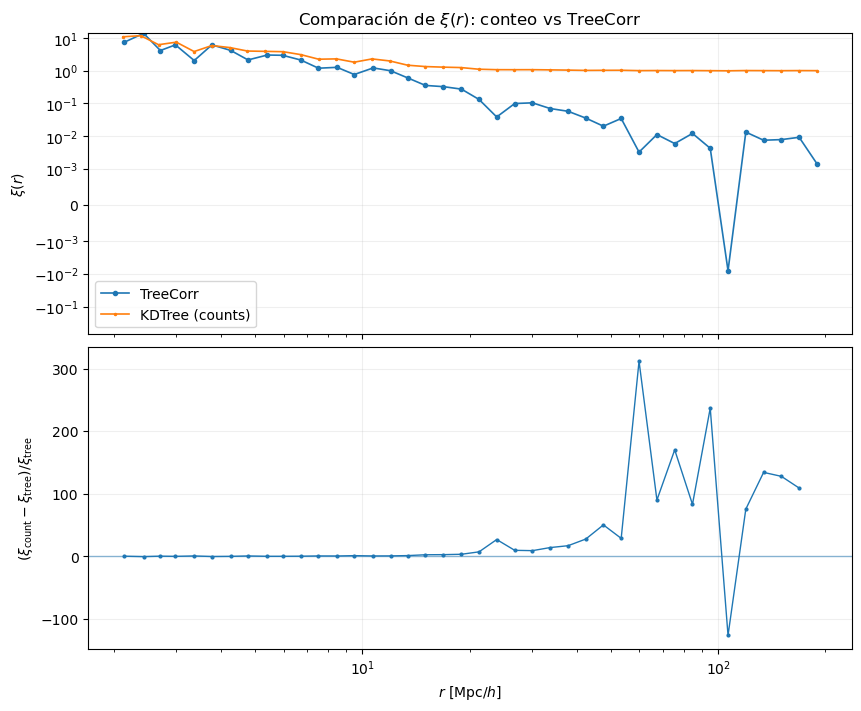

In [21]:
compare_xi_curves(
    r_count, xi_count,
    r_tree, xi_tree)

In [22]:
def benchmark_kdtree_vs_treecorr(
    pos_d, pos_r,
    rmin=2.0, rmax=200.0, nbins=40,
    fracs_d=(0.02, 0.05, 0.1, 0.2, 0.5, 1.0),
    frac_r_factor=0.25,     # frac_r = frac_d * factor (típico: random menos para prototipo)
    seed_d=42, seed_r=7,
    kdtree_verbose=False,
    treecorr_verbose=False,
    bin_slop=0.0
):
    rows = []

    for frac_d in fracs_d:
        frac_r = min(1.0, frac_d * frac_r_factor)

        # --- KDTree
        r_kd, xi_kd, info_kd = xi_landy_szalay_kdtree(
            pos_d, pos_r,
            rmin=rmin, rmax=rmax, nbins=nbins,
            frac_d=frac_d, frac_r=frac_r,
            seed_d=seed_d, seed_r=seed_r,
            verbose=kdtree_verbose
        )

        # --- TreeCorr
        r_tc, xi_tc, varxi_tc, info_tc = xi_landy_szalay_treecorr(
            pos_d, pos_r,
            rmin=rmin, rmax=rmax, nbins=nbins,
            frac_d=frac_d, frac_r=frac_r,
            seed_d=seed_d, seed_r=seed_r,
            bin_slop=bin_slop,
            verbose=treecorr_verbose
        )

        # tiempos
        t_kd = info_kd["timings"]
        t_tc = info_tc["timings"]

        rows.append({
            "frac_d": frac_d,
            "frac_r": frac_r,
            "Nd": info_kd["Nd"],
            "Nr": info_kd["Nr"],
            "KD_total_s": t_kd.get("total", np.nan),
            "KD_subsampling_s": t_kd.get("subsampling", np.nan),
            "KD_DD_s": t_kd.get("DD", np.nan),
            "KD_DR_s": t_kd.get("DR", np.nan),
            "KD_RR_s": t_kd.get("RR", np.nan),
            "KD_estimator_s": t_kd.get("estimator", np.nan),
            "TC_total_s": t_tc.get("total", np.nan),
            "TC_subsampling_s": t_tc.get("subsampling", np.nan),
            "TC_catalogs_s": t_tc.get("catalogs", np.nan),
            "TC_pair_counts_s": t_tc.get("pair_counts", np.nan),
            "TC_estimator_s": t_tc.get("estimator", np.nan),
            "speedup_TC_over_KD": (t_kd.get("total", np.nan) / t_tc.get("total", np.nan))
        })

    df = pd.DataFrame(rows)
    return df


def plot_benchmark_results(df):
    df = df.sort_values("frac_d")

    # --- Plot 1: tiempo total vs frac_d
    fig, ax = plt.subplots(1, 1, figsize=(8.5, 5.0), constrained_layout=True)
    ax.plot(df["frac_d"], df["KD_total_s"], marker="o", label="KDTree total")
    ax.plot(df["frac_d"], df["TC_total_s"], marker="o", label="TreeCorr total")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("frac_d")
    ax.set_ylabel("tiempo total [s]")
    ax.grid(alpha=0.2)
    ax.legend()
    ax.set_title("Tiempo total vs fracción (KDTree vs TreeCorr)")
    plt.show()

    # --- Plot 2: speedup
    fig, ax = plt.subplots(1, 1, figsize=(8.5, 5.0), constrained_layout=True)
    ax.plot(df["frac_d"], df["speedup_TC_over_KD"], marker="o")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("frac_d")
    ax.set_ylabel("KDTree / TreeCorr (speedup)")
    ax.grid(alpha=0.2)
    ax.set_title("Speedup: KDTree / TreeCorr (valores > 1 => TreeCorr más rápido)")
    plt.show()

    # --- Plot 3 opcional: tiempo vs Nd
    fig, ax = plt.subplots(1, 1, figsize=(8.5, 5.0), constrained_layout=True)
    ax.plot(df["Nd"], df["KD_total_s"], marker="o", label="KDTree total")
    ax.plot(df["Nd"], df["TC_total_s"], marker="o", label="TreeCorr total")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Nd (número de galaxias usadas)")
    ax.set_ylabel("tiempo total [s]")
    ax.grid(alpha=0.2)
    ax.legend()
    ax.set_title("Tiempo total vs Nd (KDTree vs TreeCorr)")
    plt.show()


C:\Users\juanr\AppData\Local\Temp\ipykernel_16908\44592622.py:75: RuntimeWarning: divide by zero encountered in divide
  xi = (ddn - 2.0 * drn + rrn) / rrn
C:\Users\juanr\AppData\Local\Temp\ipykernel_16908\44592622.py:75: RuntimeWarning: invalid value encountered in divide
  xi = (ddn - 2.0 * drn + rrn) / rrn


,frac_d,frac_r,Nd,Nr,KD_total_s,KD_subsampling_s,KD_DD_s,KD_DR_s,KD_RR_s,KD_estimator_s,TC_total_s,TC_subsampling_s,TC_catalogs_s,TC_pair_counts_s,TC_estimator_s,speedup_TC_over_KD
0,0.002,0.000050,215,273,0.020321,0.000624,0.006404,0.005686,0.007382,0.000225,0.004971,0.000652,0.000479,0.002758,0.001081,4.087992
1,0.005,0.000125,537,682,0.051149,0.000787,0.015793,0.014256,0.020276,0.000037,0.011685,0.000461,0.000511,0.009719,0.000995,4.377431
2,0.010,0.000250,1075,1365,0.118138,0.000908,0.036206,0.033567,0.047401,0.000057,0.030287,0.000753,0.000550,0.027524,0.001460,3.900563
3,0.020,0.000500,2150,2730,0.282099,0.001405,0.087471,0.082617,0.110558,0.000050,0.051219,0.000915,0.000527,0.048288,0.001489,5.507687
4,0.050,0.001250,5375,6825,0.954191,0.002885,0.273895,0.276919,0.400456,0.000035,0.173875,0.001520,0.000502,0.170567,0.001285,5.487810


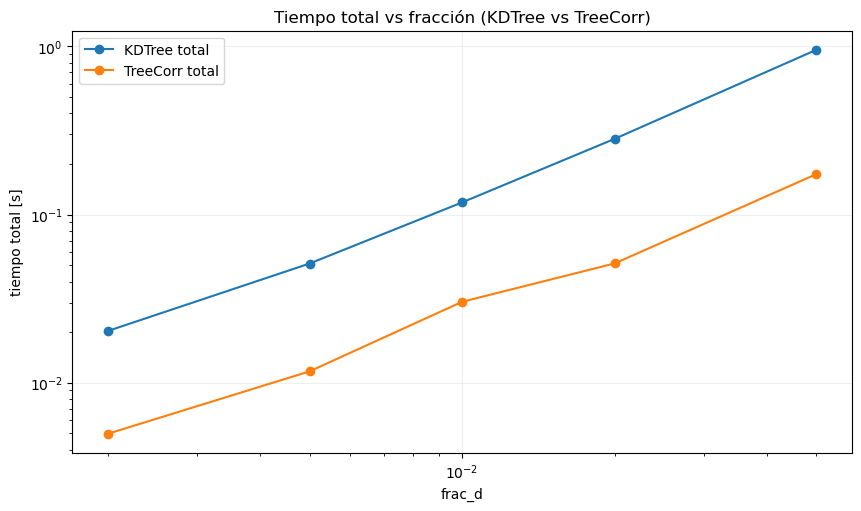

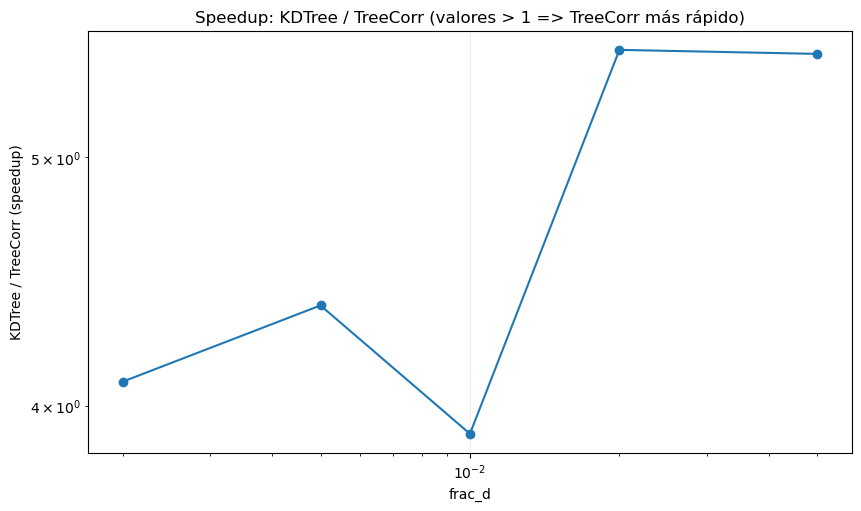

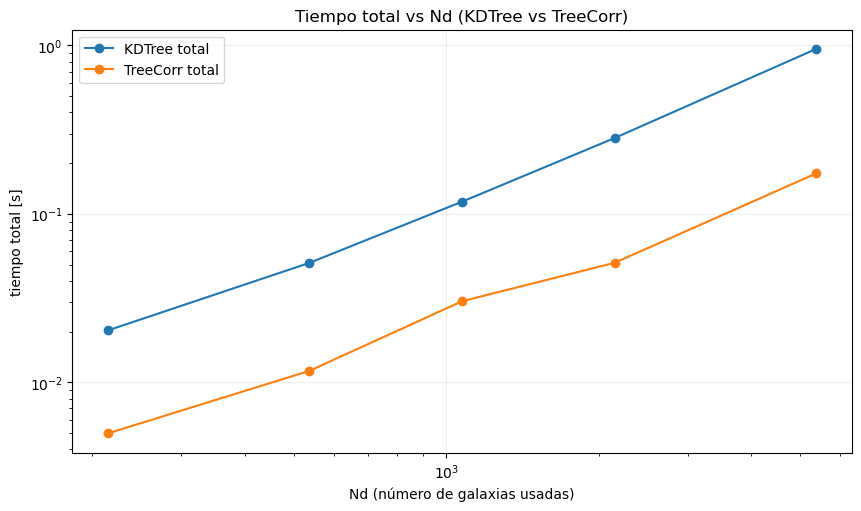

In [24]:
df = benchmark_kdtree_vs_treecorr(
    pos_d, pos_r,
    rmin=2, rmax=200, nbins=40,
    fracs_d= (0.002, 0.005, 0.01, 0.02, 0.05),#(0.02, 0.05, 0.1, 0.2, 0.5),
    frac_r_factor=0.025,
    seed_d=42, seed_r=7,
    kdtree_verbose=False,
    treecorr_verbose=False,
    bin_slop=0.0
)
display(df)
plot_benchmark_results(df)


## 4. TreeCorr 3PCF
---

In [28]:

def random_subsample_pos_and_w(pos, w=None, frac=1.0, seed=1234):
    pos = np.asarray(pos, dtype=np.float64)
    n = len(pos)
    if frac >= 1.0 or n == 0:
        return pos, None if w is None else np.asarray(w, dtype=np.float64)

    rng = np.random.default_rng(seed)
    k = max(1, int(np.floor(frac * n)))
    idx = rng.choice(n, size=k, replace=False)
    pos_sub = pos[idx]
    if w is None:
        return pos_sub, None
    return pos_sub, np.asarray(w, dtype=np.float64)[idx]


def zeta_3pcf_treecorr(
    pos_d, pos_r,
    w_d=None, w_r=None,
    rmin=10.0, rmax=60.0, nbins=6,     # bins en r (lado 1 y lado 2)
    nphi_bins=12,                      # bins en ángulo (phi) ~ theta
    frac_d=0.02, frac_r=0.01,
    seed_d=42, seed_r=7,
    bin_slop=0.3,
    verbose=True
):
    """
    3PCF zeta(r1,r2,phi) con TreeCorr usando NNNCorrelation (3D).
    Implementa estimador tipo Szapudi–Szalay:
        zeta = (DDD - 3 DDR + 3 DRR - RRR) / RRR

    Devuelve:
      rnom (bins r), phinom (bins phi), zeta (array), info
    """

    timings = {}

    # --- Subsampling
    t0 = time.perf_counter()
    pos_d_sub, w_d_sub = random_subsample_pos_and_w(pos_d, w_d, frac_d, seed_d)
    pos_r_sub, w_r_sub = random_subsample_pos_and_w(pos_r, w_r, frac_r, seed_r)
    timings["subsampling"] = time.perf_counter() - t0

    Nd, Nr = len(pos_d_sub), len(pos_r_sub)

    # --- Catálogos
    t0 = time.perf_counter()
    cat_d = treecorr.Catalog(x=pos_d_sub[:,0], y=pos_d_sub[:,1], z=pos_d_sub[:,2], w=w_d_sub)
    cat_r = treecorr.Catalog(x=pos_r_sub[:,0], y=pos_r_sub[:,1], z=pos_r_sub[:,2], w=w_r_sub)
    timings["catalogs"] = time.perf_counter() - t0

    # --- Definir correlador 3pt
    # phi_bins: TreeCorr usa ángulo interno "phi" (equivalente a theta para el triángulo).
    # Para isósceles o configuración general, TreeCorr binnea en (r, u, v) o (r1, r2, phi) según el "bin_type".
    # Aquí usamos binning en r para dos lados y phi para el ángulo.
    t0 = time.perf_counter()
    nnn = treecorr.NNNCorrelation(
        min_sep=rmin, max_sep=rmax, nbins=nbins,
        nphi_bins=nphi_bins,
        bin_slop=bin_slop,
        #sep_units=None  # no se usa en 3D cartesiano
    )
    timings["setup"] = time.perf_counter() - t0

    # --- Conteos
    # DDD
    t0 = time.perf_counter()
    nnn.process(cat_d, cat_d, cat_d)
    timings["DDD"] = time.perf_counter() - t0
    DDD = nnn.zeta.copy() if hasattr(nnn, "zeta") else nnn.weight.copy()

    # DDR (dos data, un random): hay 3 permutaciones equivalentes; TreeCorr permite procesarlas explícitamente.
    # Para evitar sesgos por orden, calculamos las tres y promediamos.
    t0 = time.perf_counter()
    nnn_ddr1 = nnn.copy(); nnn_ddr1.process(cat_d, cat_d, cat_r)
    nnn_ddr2 = nnn.copy(); nnn_ddr2.process(cat_d, cat_r, cat_d)
    nnn_ddr3 = nnn.copy(); nnn_ddr3.process(cat_r, cat_d, cat_d)
    timings["DDR"] = time.perf_counter() - t0

    DDR = (nnn_ddr1.weight + nnn_ddr2.weight + nnn_ddr3.weight) / 3.0

    # DRR (uno data, dos random): 3 permutaciones
    t0 = time.perf_counter()
    nnn_drr1 = nnn.copy(); nnn_drr1.process(cat_d, cat_r, cat_r)
    nnn_drr2 = nnn.copy(); nnn_drr2.process(cat_r, cat_d, cat_r)
    nnn_drr3 = nnn.copy(); nnn_drr3.process(cat_r, cat_r, cat_d)
    timings["DRR"] = time.perf_counter() - t0

    DRR = (nnn_drr1.weight + nnn_drr2.weight + nnn_drr3.weight) / 3.0

    # RRR
    t0 = time.perf_counter()
    nnn_rrr = nnn.copy(); nnn_rrr.process(cat_r, cat_r, cat_r)
    timings["RRR"] = time.perf_counter() - t0

    RRR = nnn_rrr.weight

    # --- Estimador Szapudi–Szalay
    t0 = time.perf_counter()
    eps = 1e-30
    zeta = (DDD - 3.0*DDR + 3.0*DRR - RRR) / (RRR + eps)
    timings["estimator"] = time.perf_counter() - t0

    timings["total"] = sum(timings.values())

    # --- Coordenadas nominales de bins
    # meanlogr / meanphi existen típicamente; si no, usamos centros geométricos.
    # TreeCorr suele proveer:
    #   nnn.meand1, nnn.meand2, nnn.meanphi o similares según binning.
    rnom = np.exp(nnn.meanlogr) if hasattr(nnn, "meanlogr") else None
    phinom = nnn.meanphi if hasattr(nnn, "meanphi") else None

    info = {
        "Nd": Nd, "Nr": Nr,
        "frac_d": frac_d, "frac_r": frac_r,
        "bin_slop": bin_slop,
        "timings": timings
    }

    if verbose:
        print("Timing 3PCF TreeCorr (s):")
        for k, v in timings.items():
            print(f"  {k:>10s}: {v:8.3f}")

    return rnom, phinom, zeta, info


In [29]:
rnom, phinom, zeta, info = zeta_3pcf_treecorr(
    pos_d, pos_r,
    w_d=None, w_r=None,
    rmin=10.0, rmax=60.0, nbins=6,     # bins en r (lado 1 y lado 2)
    nphi_bins=12,                      # bins en ángulo (phi) ~ theta
    frac_d=0.01, frac_r=0.001,
    seed_d=42, seed_r=7,
    bin_slop=0.3,
    verbose=True
)

AttributeError: 'NoneType' object has no attribute 'copy'

In [26]:
def plot_zeta_vs_theta(phinom, zeta, r_index=0):
    """
    phinom: array de ángulos (rad)
    zeta: matriz con dimensión (nbins_r, nphi_bins) o similar
    """
    if phinom is None:
        raise ValueError("No tengo phinom (meanphi). Revisa salida de TreeCorr.")
    theta = phinom  # rad

    # Si zeta es 2D (r,phi), elegimos un r_index
    z = zeta[r_index] if zeta.ndim == 2 else zeta

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 4.8), constrained_layout=True)
    ax.plot(theta, z, marker="o")
    ax.set_xlabel(r"$\theta\ \mathrm{[rad]}$")
    ax.set_ylabel(r"$\zeta(r,r,\theta)$ (estimador)")
    ax.grid(alpha=0.2)
    ax.set_title("3PCF: dependencia angular")
    plt.show()
